Mean Squared Error (KNN, k=5): 83547208502084.7969
     Actual Salary  Predicted Salary
287      2087519.0      6.460324e+06
329      3244080.0      1.904246e+06
323      5291160.0      3.009898e+06
145      8500000.0      8.854157e+06
55      12976362.0      1.857318e+07
..             ...               ...
227     14763636.0      1.090246e+07
182      2755080.0      5.586598e+06
316      4741800.0      2.914549e+06
110     22255493.0      9.097404e+06
305      2463946.0      3.260635e+06

[76 rows x 2 columns]


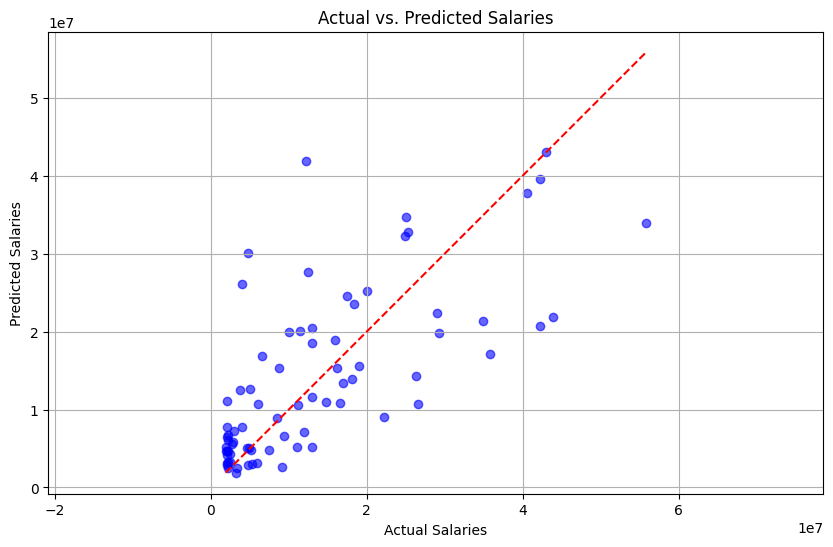

In [9]:
# Predicting using KNN
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the overall data
# data = pd.read_csv('nba_data.csv')
# Load the data per game
data = pd.read_csv('nba_dataPG.csv')


# Split the data into features and target
features = ['G', 'MP', 'FG', '3P', 'FT', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
X= data[features]
y = data['Salary']

# Scale the feature data (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the KNN regressor model with Euclidean distance (default metric)
knn = KNeighborsRegressor(n_neighbors=8, metric='euclidean')

# Fit the model
knn.fit(X_train, y_train)

# Predict salaries on the test set
y_pred = knn.predict(X_test)

# Evaluate the performance using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (KNN, k=5): {mse:.4f}')

# Create a DataFrame to display the actual vs. predicted values
results_df = pd.DataFrame({'Actual Salary': y_test, 'Predicted Salary': y_pred})

# Display the results DataFrame
print(results_df)

# Plotting Actual vs. Predicted Salaries
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ideal line
plt.title('Actual vs. Predicted Salaries')
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.grid()
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.axis('equal')  # Equal scaling for both axes
plt.show()

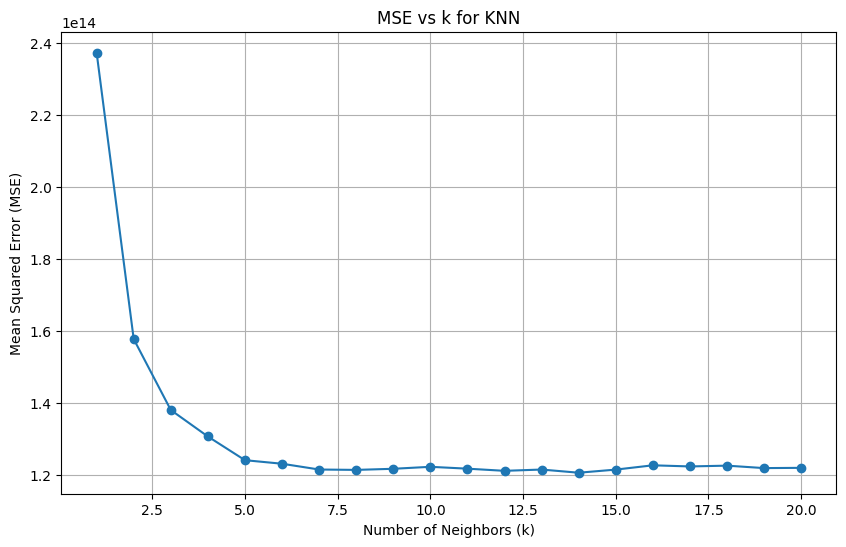

In [7]:
from sklearn.model_selection import cross_val_score
k_values = range(1, 21)  # Test k values from 1 to 20
mse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    mse = -cross_val_score(knn, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()
    mse_values.append(mse)

# Plot MSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o')
plt.title('MSE vs k for KNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.show()